<a href="https://colab.research.google.com/github/neonithinar/ML_and_DL_learning_materials_and_tryouts/blob/master/Multiclass_text_classification_stack_overflow_data_predict_the_language_of_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The problem: 
create a multiclass classifier on stackoverflow questions to identify the language which the question belongs to.

[dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to `losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import shutil, os, re, string

import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = keras.utils.get_file('stack_overflow_16k.tar.gz', url, untar= True, cache_dir='.', 
                               cache_subdir = '')
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6053888/6053168 [==============================] - 0s 0us/step


In [3]:
os.listdir('.')

['.config',
 'stack_overflow_16k.tar.gz.tar.gz',
 'README.md',
 'train',
 'test',
 'sample_data']

In [4]:
batch_size = 32

raw_train_ds = keras.preprocessing.text_dataset_from_directory('train',
                                                               batch_size= batch_size, validation_split = 0.2, subset= 'training', seed = 42)
raw_val_ds = keras.preprocessing.text_dataset_from_directory('train', batch_size= batch_size,
                                                             validation_split = 0.2, subset= 'validation', seed = 42)
raw_test_ds = keras.preprocessing.text_dataset_from_directory('test', batch_size= batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


## Visualize the data

In [5]:
print(raw_train_ds.class_names)

['csharp', 'java', 'javascript', 'python']


In [6]:
for text_batch, batch_label in raw_train_ds.take(1):
  for i in range(5):
    print(text_batch.numpy()[i])
    print(batch_label.numpy()[i])
    print()

b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constructor, w

## Data preprocessing
 The thing to note in this example is that we cannot blindly remove the ```<br> , \n, \  ``` tags and other non alphabetic representations. because they might be integral part of the programing data provided

In [7]:
max_features = 5000
sequence_length = 500

vectorize_layer = TextVectorization(max_tokens = max_features, 
                                    output_mode = 'int', output_sequence_length = sequence_length)


To create a vocabulary and other features we must first fit this TextVectorization on to the training data

In [8]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
# it is important to call adapt on the training set only. otherwise serving problems may arise idk

In [9]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [10]:
# let's make sure that everyting works fine

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("review: ", first_review)
print("Label: ", first_label)
print("vectorized review: ", vectorize_text(first_review, first_label))

review:  tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label:  tf.Tensor(1, shape=(), dtype=int32)
vectorized review:  (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70,    1,    3,   34,  888,  202,  773,  107,
           8,   41,  

In [11]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 5000


### creating train, test and validation data

In [12]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


## Create the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640128    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 640,644
Trainable params: 640,644
Non-trainable params: 0
_________________________________________________________________
None


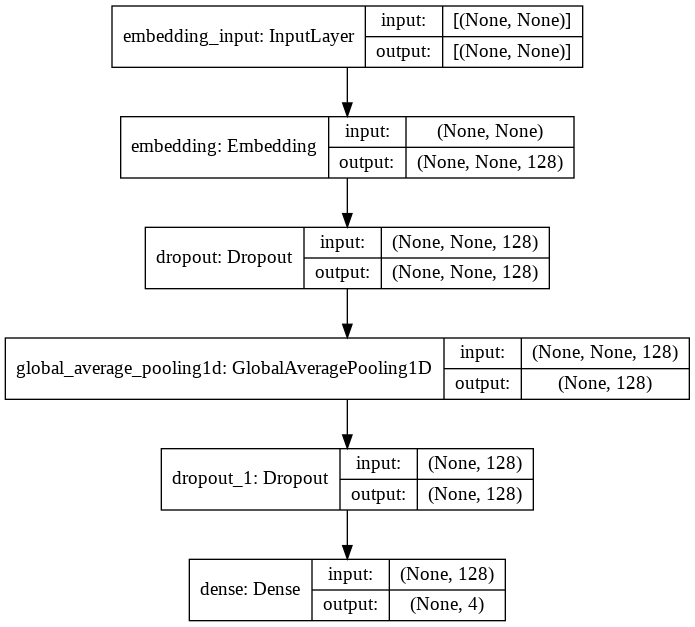

In [36]:
embedding_dim = 128
keras.backend.clear_session()
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Embedding(max_features + 1, embedding_dim), 
                                 keras.layers.Dropout(0.2), 
                                 keras.layers.GlobalAveragePooling1D(),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Dense(4)
])

print(model.summary())
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer= 'adam', metrics = ['accuracy'])
keras.utils.plot_model(model = model, show_shapes = True)



### Train the model

In [37]:
history = model.fit(train_ds, validation_data= val_ds,callbacks= early_stopping_cb, epochs = 40)

Epoch 1/40
200/200 [==============================] - 3s 12ms/step - loss: 1.3811 - accuracy: 0.2723 - val_loss: 1.3570 - val_accuracy: 0.4275
Epoch 2/40
200/200 [==============================] - 2s 11ms/step - loss: 1.3404 - accuracy: 0.4306 - val_loss: 1.2856 - val_accuracy: 0.6137
Epoch 3/40
200/200 [==============================] - 2s 11ms/step - loss: 1.2580 - accuracy: 0.5661 - val_loss: 1.1722 - val_accuracy: 0.6581
Epoch 4/40
200/200 [==============================] - 2s 11ms/step - loss: 1.1422 - accuracy: 0.6328 - val_loss: 1.0514 - val_accuracy: 0.7063
Epoch 5/40
200/200 [==============================] - 2s 11ms/step - loss: 1.0252 - accuracy: 0.6913 - val_loss: 0.9459 - val_accuracy: 0.7294
Epoch 6/40
200/200 [==============================] - 2s 11ms/step - loss: 0.9244 - accuracy: 0.7217 - val_loss: 0.8611 - val_accuracy: 0.7412
Epoch 7/40
200/200 [==============================] - 2s 11ms/step - loss: 0.8374 - accuracy: 0.7434 - val_loss: 0.7935 - val_accuracy: 0.7531

### Alternate models

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640128    
_________________________________________________________________
gru (GRU)                    (None, None, 128)         99072     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 838,788
Trainable params: 838,788
Non-trainable params: 0
_________________________________________________________________
None


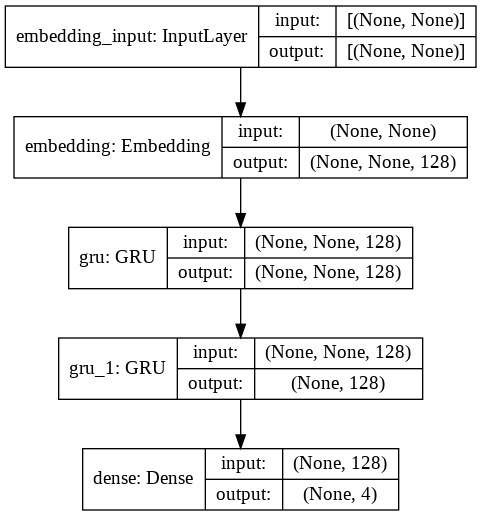

In [34]:
embedding_dim = 128
keras.backend.clear_session()
tf.random.set_seed(42)

model_test = keras.models.Sequential([
                                 keras.layers.Embedding(max_features + 1, embedding_dim), 
#                                 keras.layers.Dropout(0.2), 
                                 keras.layers.GRU(128, return_sequences= True),
                                 keras.layers.GRU(128),
                                 keras.layers.Dense(4)
])

print(model_test.summary())
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)
model_test.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer= 'adam', metrics = ['accuracy'])
keras.utils.plot_model(model = model_test, show_shapes = True)


In [35]:
history = model_test.fit(train_ds, validation_data= val_ds,callbacks= early_stopping_cb, epochs = 40)

Epoch 1/40
200/200 [==============================] - 14s 58ms/step - loss: 1.3897 - accuracy: 0.2532 - val_loss: 1.3893 - val_accuracy: 0.2356
Epoch 2/40
200/200 [==============================] - 11s 56ms/step - loss: 1.3863 - accuracy: 0.2688 - val_loss: 1.3890 - val_accuracy: 0.2344
Epoch 3/40
200/200 [==============================] - 11s 55ms/step - loss: 1.3856 - accuracy: 0.2643 - val_loss: 1.3882 - val_accuracy: 0.2344
Epoch 4/40
200/200 [==============================] - 11s 55ms/step - loss: 1.3840 - accuracy: 0.2607 - val_loss: 1.3896 - val_accuracy: 0.2344
Epoch 5/40
200/200 [==============================] - 11s 55ms/step - loss: 1.3795 - accuracy: 0.2656 - val_loss: 1.3937 - val_accuracy: 0.2362
Epoch 6/40
200/200 [==============================] - 11s 55ms/step - loss: 1.3750 - accuracy: 0.2675 - val_loss: 1.3958 - val_accuracy: 0.2350
Epoch 7/40
200/200 [==============================] - 11s 56ms/step - loss: 1.3729 - accuracy: 0.2714 - val_loss: 1.3948 - val_accuracy:

so thats no better. so I think going simpler is better

### Evaluate the model

In [38]:
model.evaluate(test_ds)

250/250 [==============================] - 1s 3ms/step - loss: 0.5425 - accuracy: 0.7999


[0.5425498485565186, 0.799875020980835]

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

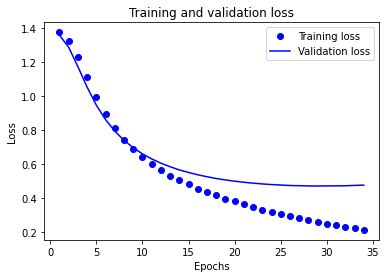

In [41]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

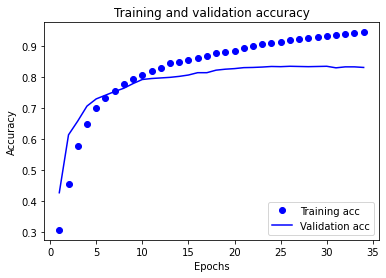

In [42]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Export the model

In [45]:
export_model = keras.Sequential([
                                 vectorize_layer, 
                                 model, 
                                 keras.layers.Activation('sigmoid')
])

export_model.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits= True), optimizer= 'adam', metrics= ['accuracy'])

In [46]:
#model evaluation
export_model.evaluate(raw_test_ds)

250/250 [==============================] - 3s 12ms/step - loss: 0.5555 - accuracy: 0.7968


[0.5425497889518738, 0.799875020980835]